# Statistical Analysis for Delta-radiomics Model dataset
The Delta-radiomics model dataset contains 68 patients, and it was used in the Delta-radiomics model article (Van Dijk et. al. 2019). This dataset contains 68 patients. For more information about it take a look at the following link.

https://www.nature.com/articles/s41598-019-48184-3

In this notebook, I will implement Surface Dice, residual scatter plot, violin plot, and heatmaps along with different statistical tests to compare the surface area features made based on manual contour and deep learning contours.

In [3]:
# Import packages
# General packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro, levene, wilcoxon, f_oneway
from scipy.stats import kruskal, bartlett, ttest_ind, ttest_rel

# Image analysis packages
import SimpleITK as sitk
import seg_metrics.seg_metrics as sg
from surface_distance import metrics
from surface_distance.metrics import *

c:\Users\BahrdoH\AppData\Local\anaconda3\envs\radiomics_env\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Making Sanne Dataset


In [2]:
def normalizing_feature(x):
    normalized_x = (x - np.mean(x)) / np.std(x)
    return normalized_x

def normalizing_feature(x):
    normalized_x = (x - np.mean(x)) / np.std(x)
    return normalized_x

def xer_label_maker(diagnosis):

    if diagnosis in [3, 4]:
        return 1

    elif diagnosis in [1, 2]:
        return 0
    
    else:
        return 2

def xer_label_maker1(diagnosis):

    if diagnosis in [2, 3, 4]:
        return 1

    elif diagnosis in [1]:
        return 0
    
    else:
        return 2

In [ ]:
mc_bsl_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Sanne_dataset/Rf_bsl_mc_sanne.xlsx'
mc_wk3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Sanne_dataset/Rf_wk3_mc_sanne.xlsx'
dlc_bsl_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Sanne_dataset/Rf_bsl_dlc_sanne.xlsx'
dlc_wk3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Sanne_dataset/Rf_wk3_dlc_sanne.xlsx'
label_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Sanne_dataset/endpoints_xer2.xls'
xer_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Sanne_dataset/Xerostomia_dataset.xlsx'

# Read the dataframe.
mc_wk3_df = pd.read_excel(mc_wk3_path).drop(columns=['Unnamed: 0'])
mc_bsl_df = pd.read_excel(mc_bsl_path).drop(columns=['Unnamed: 0'])
dlc_wk3_df = pd.read_excel(dlc_wk3_path).drop(columns=['Unnamed: 0'])
dlc_bsl_df = pd.read_excel(dlc_bsl_path).drop(columns=['Unnamed: 0'])
label_df = pd.read_excel(label_path)
xer_df = pd.read_excel(xer_path)
xer_df['UMCG'] = xer_df['UMCG'].fillna(0).astype(int)
xer_chosen_df = xer_df[xer_df.UMCG.isin(label_df.umcgnum)].reset_index().drop(columns=['index'])

# Slicing the needed part
xer_chosen_df = xer_chosen_df.loc[:,['UMCG', 'Parotid_R_Dmean',	'Parotid_L_Dmean',	'Parotid_Dmean']].reset_index().drop(columns=['index'])
xer_chosen_df['OAR'] = xer_chosen_df.idxmin(axis=1)
xer_chosen_df['OAR'] = xer_chosen_df['OAR'].str.replace('_Dmean', '')
xer_chosen_df['Contra_Dmean'] = xer_chosen_df.min(axis=1)
xer_chosen_df = xer_chosen_df.drop(columns=['Parotid_R_Dmean',	'Parotid_L_Dmean',	'Parotid_Dmean'])

mc_wk3_df = mc_wk3_df.loc[:, ['ID', 'OAR', 'original_shape_SurfaceArea']].rename(columns={'original_shape_SurfaceArea': 'surface_wk3_mc'}).reset_index().drop(columns=['index'])
mc_wk3_df['OAR'] = mc_wk3_df['OAR'].str.replace('parotis_li', 'Parotid_L')
mc_wk3_df['OAR'] = mc_wk3_df['OAR'].str.replace('parotis_re', 'Parotid_R')
mc_bsl_df = mc_bsl_df.loc[:, ['ID', 'OAR', 'original_shape_SurfaceArea']].rename(columns={'original_shape_SurfaceArea': 'surface_bsl_mc'}).reset_index().drop(columns=['index'])
mc_bsl_df['OAR'] = mc_bsl_df['OAR'].str.replace('parotis_li', 'Parotid_L')
mc_bsl_df['OAR'] = mc_bsl_df['OAR'].str.replace('parotis_re', 'Parotid_R')

dlc_wk3_df = dlc_wk3_df.loc[:, ['ID', 'OAR', 'original_shape_SurfaceArea']].rename(columns={'original_shape_SurfaceArea': 'surface_wk3_dlc'}).reset_index().drop(columns=['index'])
dlc_bsl_df = dlc_bsl_df.loc[:, ['ID', 'OAR', 'original_shape_SurfaceArea']].rename(columns={'original_shape_SurfaceArea': 'surface_bsl_dlc'}).reset_index().drop(columns=['index'])

label_df = label_df.loc[:, ['umcgnum', 'Pati_baseline', 'Pati_6m',	'Pati_12m']].reset_index().drop(columns=['index'])

dlc_bsl_final_df = pd.DataFrame()
dlc_wk3_final_df = pd.DataFrame()

for counter, raw in xer_chosen_df.iterrows():
    assistant_bsl_df = dlc_bsl_df[dlc_bsl_df.ID == raw.UMCG]
    
    assistant_bsl_df = assistant_bsl_df[assistant_bsl_df.OAR.str.contains(raw.OAR)]
    assistant_wk3_df = dlc_wk3_df[dlc_wk3_df.ID == raw.UMCG]
    assistant_wk3_df = assistant_wk3_df[assistant_wk3_df.OAR.str.contains(raw.OAR)]
    dlc_bsl_final_df = pd.concat([dlc_bsl_final_df,assistant_bsl_df])
    dlc_wk3_final_df = pd.concat([dlc_wk3_final_df,assistant_wk3_df])

dlc_bsl_final_df = dlc_bsl_final_df.reset_index().drop(columns=['index'])
dlc_bsl_final_df = dlc_bsl_final_df.rename(columns={'OAR': 'OAR_bsl_dlc'})
dlc_wk3_final_df = dlc_wk3_final_df.reset_index().drop(columns=['index'])
dlc_wk3_final_df = dlc_wk3_final_df.rename(columns={'OAR': 'OAR_wk3_dlc'})

mc_bsl_final_df = pd.DataFrame()
mc_wk3_final_df = pd.DataFrame()

for counter, raw in xer_chosen_df.iterrows():
    assistant_bsl_df = mc_bsl_df[mc_bsl_df.ID == raw.UMCG]
    assistant_bsl_df = assistant_bsl_df[assistant_bsl_df.OAR.str.contains(raw.OAR)]
    assistant_wk3_df = mc_wk3_df[mc_wk3_df.ID == raw.UMCG]
    assistant_wk3_df = assistant_wk3_df[assistant_wk3_df.OAR.str.contains(raw.OAR)]

    # Try to find Tia version
    assistant_bsl_df1 = assistant_bsl_df[assistant_bsl_df.OAR.str.contains('TA')]
    assistant_wk3_df1 = assistant_wk3_df[assistant_wk3_df.OAR.str.contains('TA')]

    assistant_bsl_extra_df1 = assistant_bsl_df[~(assistant_bsl_df.OAR.str.contains('TA'))]
    assistant_wk3_extra_df1 = assistant_wk3_df[~(assistant_wk3_df.OAR.str.contains('TA'))]

    if assistant_bsl_df1.shape[0] == 1 and assistant_wk3_df1.shape[0] == 1:
        mc_bsl_final_df = pd.concat([mc_bsl_final_df,assistant_bsl_df1])
        mc_wk3_final_df = pd.concat([mc_wk3_final_df,assistant_wk3_df1])
    
    elif assistant_bsl_df1.shape[0] == 0 and assistant_wk3_df1.shape[0] == 0:
        mc_bsl_final_df = pd.concat([mc_bsl_final_df,assistant_bsl_extra_df1])
        mc_wk3_final_df = pd.concat([mc_wk3_final_df,assistant_wk3_extra_df1])

    elif (assistant_bsl_df1.shape[0] == 0 and assistant_wk3_df1.shape[0] == 1) and (assistant_wk3_extra_df1.shape[0] == 1):
        mc_bsl_final_df = pd.concat([mc_bsl_final_df,assistant_bsl_extra_df1])
        mc_wk3_final_df = pd.concat([mc_wk3_final_df,assistant_wk3_extra_df1])
    
    elif (assistant_bsl_df1.shape[0] == 1 and assistant_wk3_df1.shape[0] == 0) and (assistant_bsl_extra_df1.shape[0] == 1):
        mc_bsl_final_df = pd.concat([mc_bsl_final_df,assistant_bsl_extra_df1])
        mc_wk3_final_df = pd.concat([mc_wk3_final_df,assistant_wk3_extra_df1])

    elif (assistant_bsl_df1.shape[0] == 0 and assistant_wk3_df1.shape[0] == 1) and (assistant_wk3_extra_df1.shape[0] == 0):
        mc_bsl_final_df = pd.concat([mc_bsl_final_df,assistant_bsl_extra_df1])
        mc_wk3_final_df = pd.concat([mc_wk3_final_df,assistant_wk3_df1])    

    elif (assistant_bsl_df1.shape[0] == 1 and assistant_wk3_df1.shape[0] == 0) and (assistant_bsl_extra_df1.shape[0] == 0):
        mc_bsl_final_df = pd.concat([mc_bsl_final_df,assistant_bsl_df1])
        mc_wk3_final_df = pd.concat([mc_wk3_final_df,assistant_wk3_extra_df1])

mc_bsl_final_df = mc_bsl_final_df.reset_index().drop(columns=['index'])
mc_bsl_final_df = mc_bsl_final_df.rename(columns={'OAR': 'OAR_bsl_mc'})
mc_wk3_final_df = mc_wk3_final_df.reset_index().drop(columns=['index'])
mc_wk3_final_df = mc_wk3_final_df.rename(columns={'OAR': 'OAR_wk3_mc'})

# Makr the final dataset
mc_final_df = mc_bsl_final_df.merge(mc_wk3_final_df, on='ID', how='inner')
mc_final_df = mc_final_df.merge(dlc_wk3_final_df, on='ID', how='inner')
mc_final_df = mc_final_df.merge(dlc_bsl_final_df, on='ID', how='inner')
mc_final_df = mc_final_df.merge(xer_chosen_df, left_on='ID', right_on='UMCG', how='inner')
mc_final_df = mc_final_df.merge(label_df, left_on='ID', right_on='umcgnum', how='inner')
mc_final_df = mc_final_df.drop(columns=['UMCG', 'umcgnum'])

# make delta_radiomic
mc_final_df['delta_surf_mc'] = (mc_final_df.surface_wk3_mc - mc_final_df.surface_bsl_mc) / 100
mc_final_df['delta_surf_dlc'] = (mc_final_df.surface_wk3_dlc - mc_final_df.surface_bsl_dlc) / 100 
mc_final_df['delta_surf_mcdlc'] = (mc_final_df.surface_wk3_dlc - mc_final_df.surface_bsl_mc) / 100 

# Make 12 and 6 month datasets
six_month_df = mc_final_df[~(mc_final_df.Pati_6m == 2)]
#six_month_df = six_month_df[~(six_month_df.Pati_baseline == 2)]
six_month_df = six_month_df.reset_index().drop(columns=['index'])

twelve_month_df = mc_final_df[~(mc_final_df.Pati_12m == 2)]
#twelve_month_df = twelve_month_df[~(twelve_month_df.Pati_baseline == 2)]
twelve_month_df = twelve_month_df.reset_index().drop(columns=['index'])

In [21]:
def making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, line=False, line_info = [], logistic=True):
    plt.figure(figsize=(10,10))

    for counter, x_element in enumerate(x_element_list): 
        plt.scatter(x=x_element, y=y_element_list[counter], color=color_list[counter], alpha=alpha_list[counter], marker='o', label=label_list[counter])

        if logistic:
            X = x_element.values.reshape(-1, 1)
            y = y_element_list[counter].values.reshape(-1, 1)

            # Create and fit a linear regression model
            model = LinearRegression()
            model.fit(X, y)

            plt.plot(X, model.predict(X), color='salmon',  linestyle=':', linewidth=2, label='Fitted Line')
    
    if line:
        plt.plot(line_info[0], line_info[1], label=line_info[2])



    # Add labels to the plot
    plt.xlabel(figure_dict['x'], fontsize=16)
    plt.ylabel(figure_dict['y'], fontsize=16)

    # Add a title to the plot
    plt.title(figure_dict['title'], fontsize=18)

    # Add a legend to the plot
    plt.legend()

    # Add support lines in the x and y axes
    plt.grid(True, linestyle='--', alpha=0.5)

    # Save this plot
    plt.savefig('surface_vol.png')
    # Display the plot
    plt.show()

def making_histogram(element_list, color_list, label_list, alpha_list, figure_dict):
    # Create a histogram
    plt.figure(figsize=(10, 5))
    n, bins, patches = plt.hist(element_list[0], bins=30, color=color_list[0], density=True, edgecolor='black', alpha=0.7, label=label_list[0])

    # Add a line plot (probability density function)
    sns.kdeplot(element_list[0], color='darkgreen', linestyle='dashed')

    plt.axvline(x = np.mean(element_list[0]), color = "darkgreen", linestyle='--', label=f'Mean {label_list[0]}')

    y_place = (np.max(n) * 3) / 4.
    # Annotate the mean value with text
    plt.annotate(f'Mean: {np.mean(element_list[0]):.2f}',
                 xy=(np.mean(element_list[0]), y_place),
                 xytext=(np.mean(element_list[0]) - np.mean(element_list[0]) * 0.15, y_place),
                 arrowprops=dict(arrowstyle='->', edgecolor='black', facecolor='white'),
                 color='darkgreen',
                 fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white'))




    # Add labels to the plot
    plt.xlabel(figure_dict['x'], fontsize=16)
    plt.ylabel(figure_dict['y'], fontsize=16)

    # Add a title to the plot
    plt.title(figure_dict['title'], fontsize=18)

    # Add a legend to the plot
    plt.legend()

    # Save this plot
    plt.savefig('Surface Dice.png')

    # Display the plot
    plt.show()

def making_violin_plot(category_df):

    # Create a violin plot using Seaborn
    sns.set(style="whitegrid")
    sns.catplot(kind='violin', data=category_df, height=8, aspect=1.5, palette="Set2")

    # Customize labels and title if needed
    plt.xlabel('Categories', fontsize=16)
    plt.ylabel('Delta Surface Area', fontsize=16)
    plt.title('Delta Surface Area', fontsize=18)
    plt.tight_layout()

    plt.savefig('aaa.png')
    # Show the plot
    plt.show()
    
def calculating_surface_dice(mc_nifti_path, dlc_nifti_path, labels, tolerance):
    surface_features_dict = {}
    for r, d, f in os.walk(mc_nifti_path):
        subfolders = [os.path.join(r, folder) for folder in d]

        for subf in subfolders:

            try:

                directions = os.listdir(subf)
                    
                for direction in directions:

                    if '.nii' in direction:
                    # Makr path to patient DLC NIFTI file
                        pat_ml_path = os.path.join(subf, direction)
                        

                        # Extract the name of the OAR
                        assistant_list = pat_ml_path.split('\\')
                        oar_name =assistant_list[-1][:-4]
                        
                        # Extract the patient ID
                        subf_list = subf.split('\\')
                        patient_id = subf_list[1]

                        print(f'Patient {patient_id} has started')

                        target_nifti_path = os.path.join(dlc_nifti_path, patient_id)

                        for r, d, f in os.walk(target_nifti_path):
                            subfolders1 = [os.path.join(r, folder) for folder in d]
                            #print(subfolders1)
                            if len(subfolders1) !=0:
                                for subf1 in subfolders1:
                                    assistant_path = os.listdir(subf1)
                                    

                                    for name in assistant_path:
                                        #print(name)
                                        if  '.nii' in name.lower() and oar_name.lower() in name.lower():
                                            
                                            pat_dlc_path = os.path.join(subf1, name)
                                            #print('hiiiiiii', pat_dlc_path)

                            #else:
                            #    if 'total' in oar_name:
                            #        pat_dlc_path = os.path.join(dlc_nifti_path, patient_id, f'{oar_name}.nii')
                                    #print(pat_dlc_path)
                                
                            #    else:
                            #        pat_dlc_path = os.path.join(dlc_nifti_path, patient_id, f'DLC_{oar_name}.nii')
                                    
                                    
                        print(f'{oar_name} match for this patient has been found')

                        csv_file = 'metrix.csv'
                        #print(pat_dlc_path)
                        metrics = sg.write_metrics(labels=labels,  # exclude background
                                        gdth_path=pat_ml_path,
                                        pred_path=pat_dlc_path,
                                        csv_file=csv_file)
                
                        vol_gt = sitk.GetArrayFromImage(sitk.ReadImage(pat_ml_path))
                        mask_gt = vol_gt.astype(dtype=bool)
                        vol_seg = sitk.GetArrayFromImage(sitk.ReadImage(pat_dlc_path))
                        mask_seg = vol_seg.astype(dtype=bool)
                        #print(mask_gt)
                        voxel_spacing = sitk.ReadImage(pat_ml_path).GetSpacing()
                        

                        info_image = compute_surface_distances(mask_gt=mask_gt, mask_pred=mask_seg, spacing_mm=voxel_spacing)  

                        surface_dice = compute_surface_dice_at_tolerance(surface_distances=info_image, tolerance_mm=tolerance)

                        # Add new features to the dictionary
                        surface_features_dict[(patient_id, oar_name)] = [surface_dice]
                        print(f'Patient {patient_id} has finished')

            except Exception as e:
                print(e)
        
    df = pd.DataFrame.from_dict(surface_features_dict).transpose()
    df = df.rename(columns={0:'OAR', 1:'Surface_dice'})
    return df

In [ ]:
mc_nifti_path = '//zkh/appdata/RTDicom/Projectline_HNC_modelling/OPC_data/ART Hooman/Hooman_project_data/MC_Baseline_Contrast_Checker_NIFTI'
dlc_nifti_path = '//zkh/appdata/RTDicom/Projectline_HNC_modelling/OPC_data/ART Hooman/Hooman_project_data/DLC_baseline_NIFTI'
labels = [0, 1]
tolerance = 5

df = calculating_surface_dice(mc_nifti_path, dlc_nifti_path, labels, tolerance)
df.to_excel('mc_with_5.xlsx')

---
Evaluate Delta Surface value by using manual contours both for baseline and week3, deep learning contours for baseline and week3, and manual contours for baseline and deep learning contours for week3. 

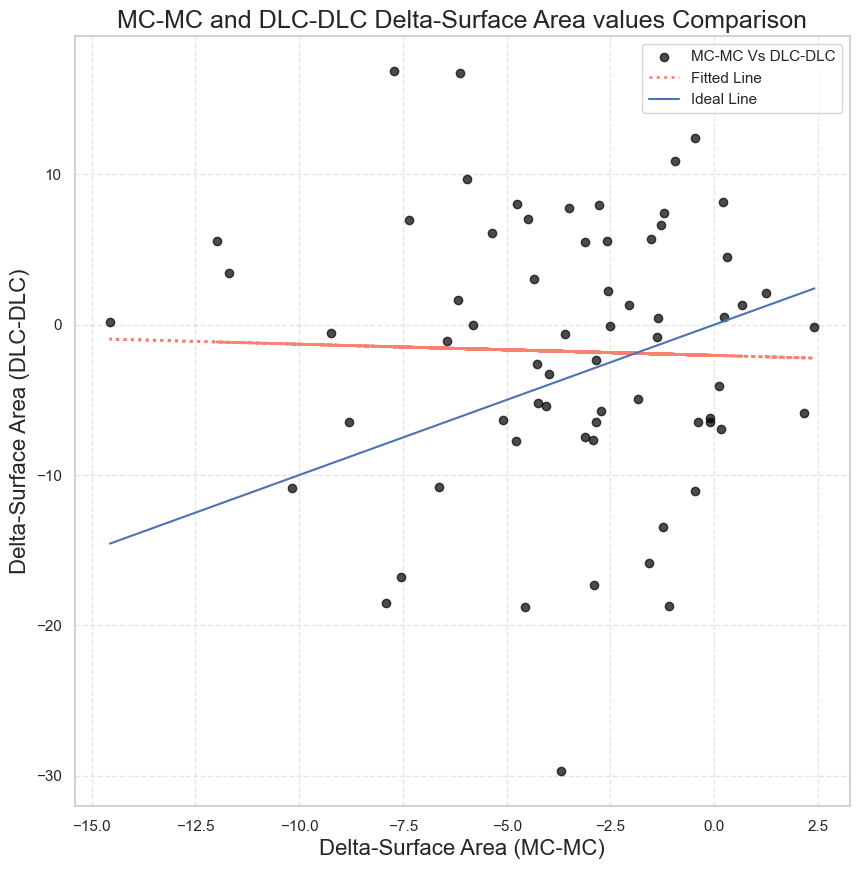

In [25]:

x_element_list = [twelve_month_df.delta_surf_mc]
y_element_list = [twelve_month_df.delta_surf_mcdlc]

line_info= [[np.min(twelve_month_df.delta_surf_mc) - 0.01, np.max(twelve_month_df.delta_surf_mc) + 0.01], 
            [np.min(twelve_month_df.delta_surf_mc) - 0.01, np.max(twelve_month_df.delta_surf_mc) + 0.01], 'Ideal Line']

color_list = ['black']
label_list = ['MC-MC Vs DLC-DLC']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta-Surface Area (MC-MC)', 'y': 'Delta-Surface Area (DLC-DLC)', 'title':'MC-MC and DLC-DLC Delta-Surface Area values Comparison'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)

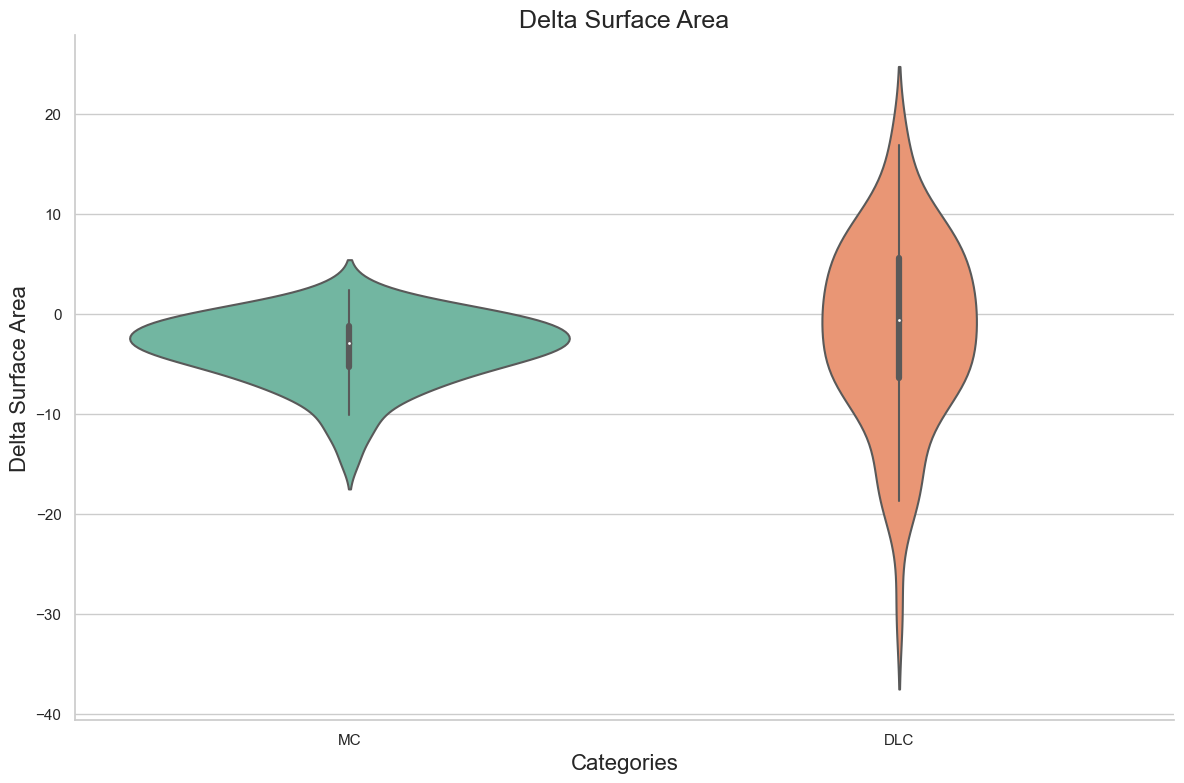

In [23]:
# Extract the relevant columns from each DataFrame
mc_data = twelve_month_df.delta_surf_mc.reset_index(drop=True)
#without_data = dlc_without[['original_shape_SurfaceArea']].reset_index(drop=True)
with_data = twelve_month_df.delta_surf_dlc.reset_index(drop=True)

# Create the DataFrame
category_df = pd.DataFrame({'MC': twelve_month_df.delta_surf_mc,
                            #'Without': without_data['original_shape_SurfaceArea'],
                            'DLC': twelve_month_df.delta_surf_mcdlc})

making_violin_plot(category_df)

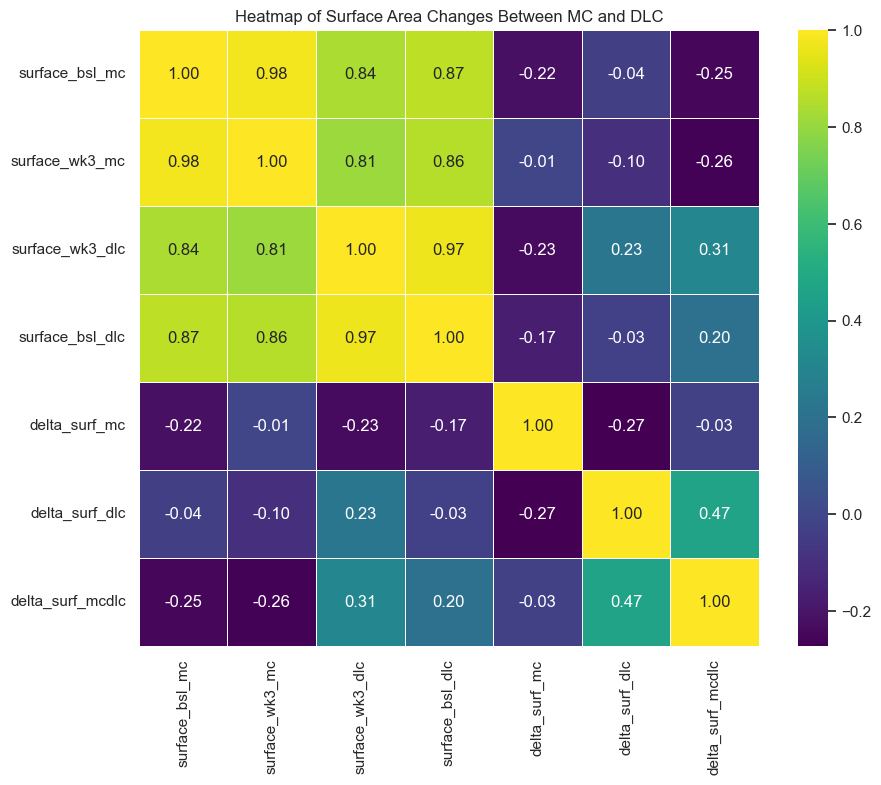

In [24]:
aaa = twelve_month_df[['surface_bsl_mc', 'surface_wk3_mc', 'surface_wk3_dlc', 'surface_bsl_dlc', 'delta_surf_mc', 'delta_surf_dlc', 'delta_surf_mcdlc']]
corre = aaa.corr()


# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corre, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Surface Area Changes Between MC and DLC')
# Save this plot
plt.savefig('heatmap.png', bbox_inches='tight')
plt.show()

In [229]:
# Check the normality
stat, p_value = shapiro(twelve_month_df['delta_surf_dlc'])
print(stat, p_value)

stat, p_value = shapiro(twelve_month_df['delta_surf_mc'])
print(stat, p_value)

stat, p_value = shapiro(twelve_month_df['delta_surf_mcdlc'])
print(stat, p_value)

0.9838851690292358 0.5481081604957581
0.950962245464325 0.010980945080518723
0.9895695447921753 0.8562659621238708


In [230]:
# Perform Levene's test
statistic, p_value = levene(twelve_month_df['delta_surf_dlc'], twelve_month_df['delta_surf_mc'])

# Print the results
print("Test Statistic:", statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in variances.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference")

Test Statistic: 11.303581155212086
p-value: 0.0010163254829623463
Reject the null hypothesis: There is a significant difference in variances.


In [231]:
# Perform Levene's test
statistic, p_value = levene(twelve_month_df['delta_surf_dlc'], twelve_month_df['delta_surf_mcdlc'])

# Print the results
print("Test Statistic:", statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in variances.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference")

Test Statistic: 11.52619258673349
p-value: 0.0009104045185463231
Reject the null hypothesis: There is a significant difference in variances.


In [232]:
# Perform Levene's test
statistic, p_value = levene(twelve_month_df['delta_surf_mc'], twelve_month_df['delta_surf_mcdlc'])

# Print the results
print("Test Statistic:", statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in variances.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference")

Test Statistic: 42.46483666687151
p-value: 1.4444297313025388e-09
Reject the null hypothesis: There is a significant difference in variances.


In [233]:
# Perform the Wilcoxon signed-rank test
statistic, p_value = wilcoxon(twelve_month_df['delta_surf_dlc'], twelve_month_df['delta_surf_mc'])

# Output the test statistic and p-value
print("Wilcoxon signed-rank test statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the paired samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the paired samples.")

Wilcoxon signed-rank test statistic: 1006.0
p-value: 0.5250279872458097
Fail to reject the null hypothesis: There is no significant difference between the paired samples.


In [234]:
# Perform the Wilcoxon signed-rank test
statistic, p_value = wilcoxon(twelve_month_df['delta_surf_dlc'], twelve_month_df['delta_surf_mcdlc'])

# Output the test statistic and p-value
print("Wilcoxon signed-rank test statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the paired samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the paired samples.")

Wilcoxon signed-rank test statistic: 320.0
p-value: 5.225626023398327e-07
Reject the null hypothesis: There is a significant difference between the paired samples.


In [235]:
# Perform the Wilcoxon signed-rank test
statistic, p_value = wilcoxon(twelve_month_df['delta_surf_mc'], twelve_month_df['delta_surf_mcdlc'])

# Output the test statistic and p-value
print("Wilcoxon signed-rank test statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the paired samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the paired samples.")

Wilcoxon signed-rank test statistic: 384.0
p-value: 4.046091238401495e-06
Reject the null hypothesis: There is a significant difference between the paired samples.


In [236]:
# Perform Bartlett's test
statistic, p_value = kruskal(twelve_month_df['delta_surf_dlc'], twelve_month_df['delta_surf_mc'], twelve_month_df['delta_surf_mcdlc'])

print(statistic, p_value)

23.25305129873425 8.926147658595096e-06


---
# Old Dataset

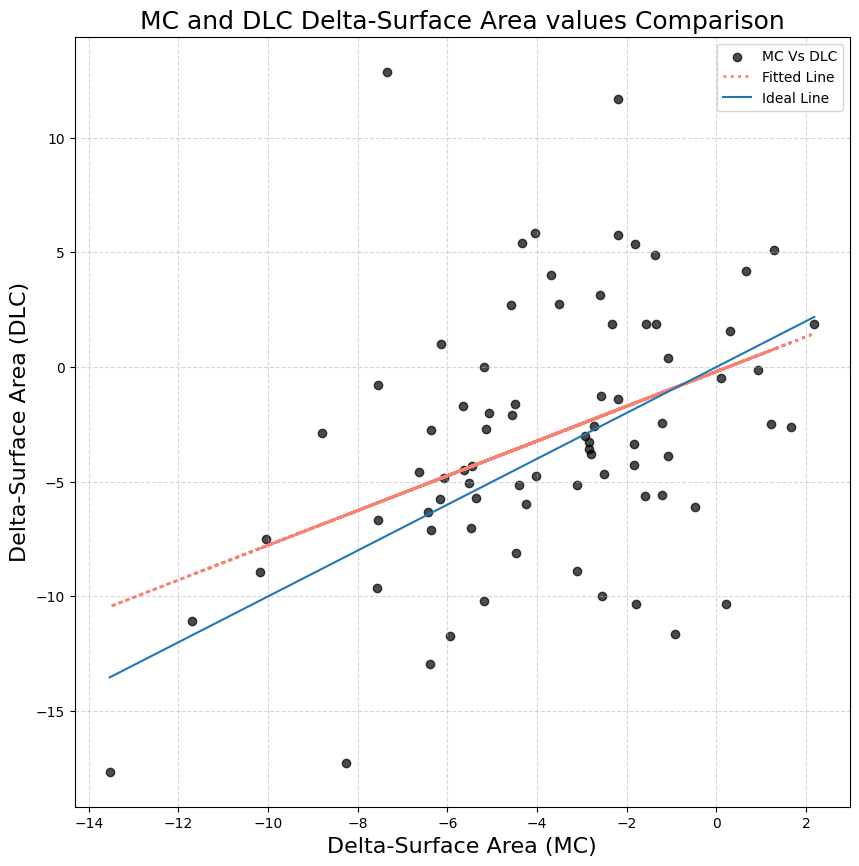

In [19]:
x_element_list = [mc_final_df.delta_surf_mc]
y_element_list = [mc_final_df.delta_surf_dlc]

line_info= [[np.min(mc_final_df.delta_surf_mc) - 0.01, np.max(mc_final_df.delta_surf_mc) + 0.01], 
            [np.min(mc_final_df.delta_surf_mc) - 0.01, np.max(mc_final_df.delta_surf_mc) + 0.01], 'Ideal Line']

color_list = ['black']
label_list = ['MC Vs DLC']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta-Surface Area (MC)', 'y': 'Delta-Surface Area (DLC)', 'title':'MC and DLC Delta-Surface Area values Comparison'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info, True)

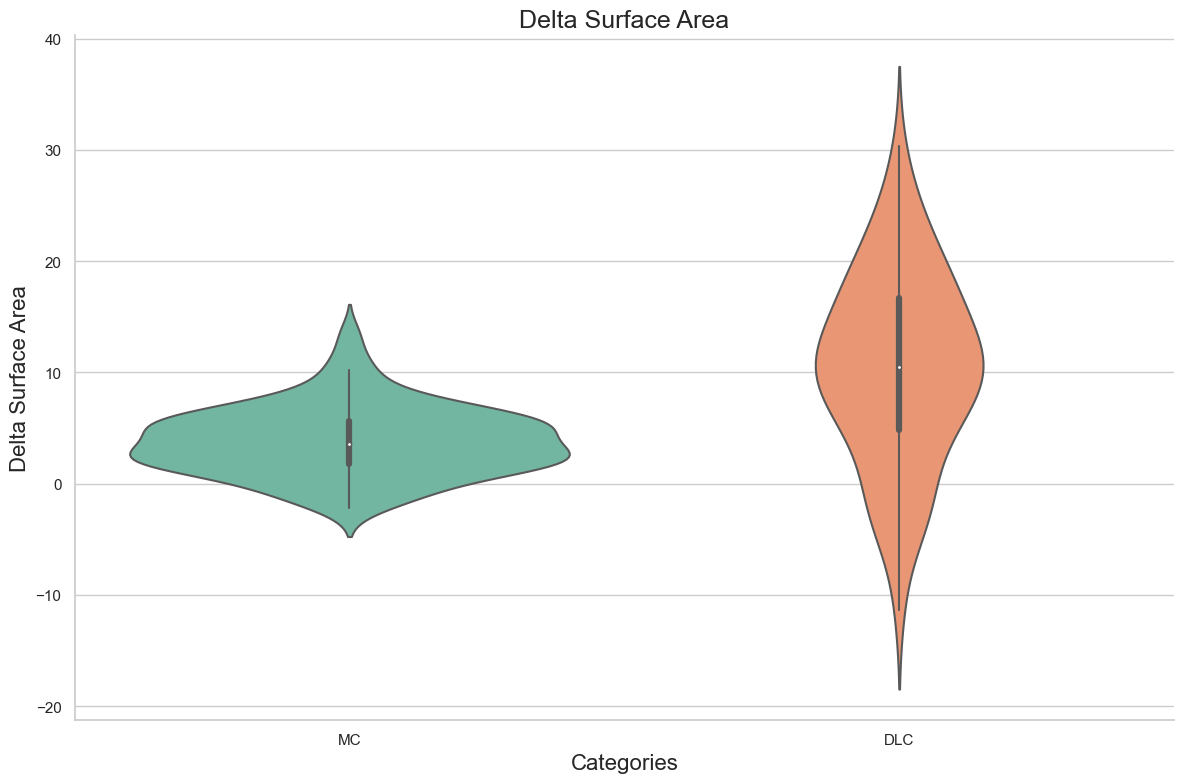

In [34]:
# Extract the relevant columns from each DataFrame
mc_data = mc_final_df.delta_surf_mc.reset_index(drop=True)
#without_data = dlc_without[['original_shape_SurfaceArea']].reset_index(drop=True)
with_data = mc_final_df.delta_surf_dlc.reset_index(drop=True)

# Create the DataFrame
category_df = pd.DataFrame({'MC': mc_final_df.delta_surf_mc,
                            #'Without': without_data['original_shape_SurfaceArea'],
                            'DLC': mc_final_df.delta_surf_mcdlc})

making_violin_plot(category_df)

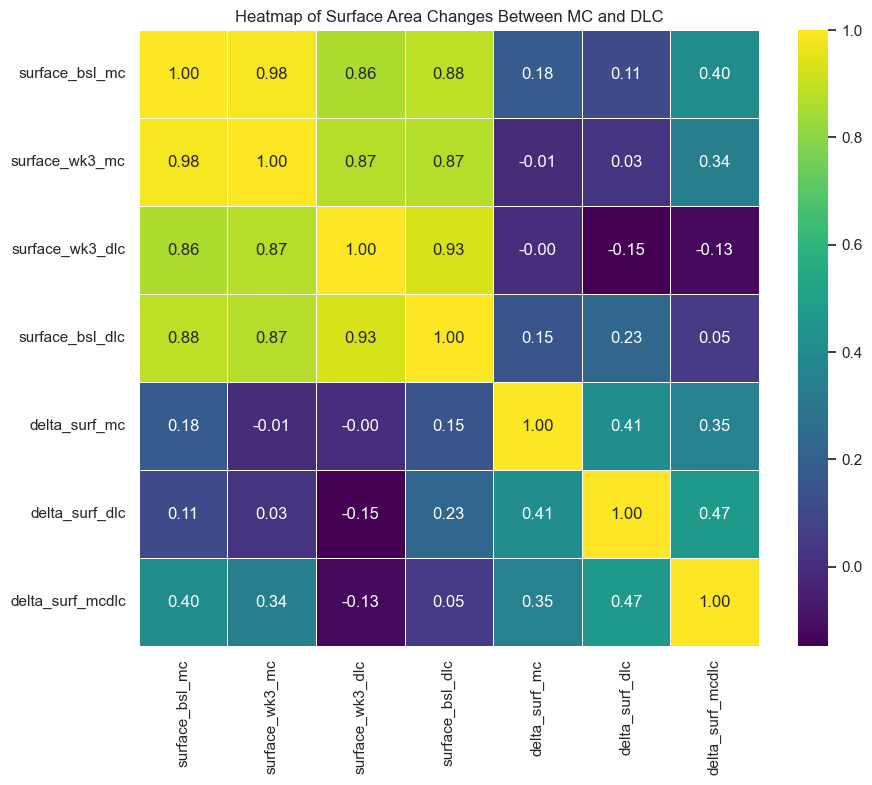

In [62]:
aaa = mc_final_df[['surface_bsl_mc', 'surface_wk3_mc', 'surface_wk3_dlc', 'surface_bsl_dlc', 'delta_surf_mc', 'delta_surf_dlc', 'delta_surf_mcdlc']]
corre = aaa.corr()


# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corre, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Surface Area Changes Between MC and DLC')
# Save this plot
plt.savefig('heatmap.png', bbox_inches='tight')
plt.show()

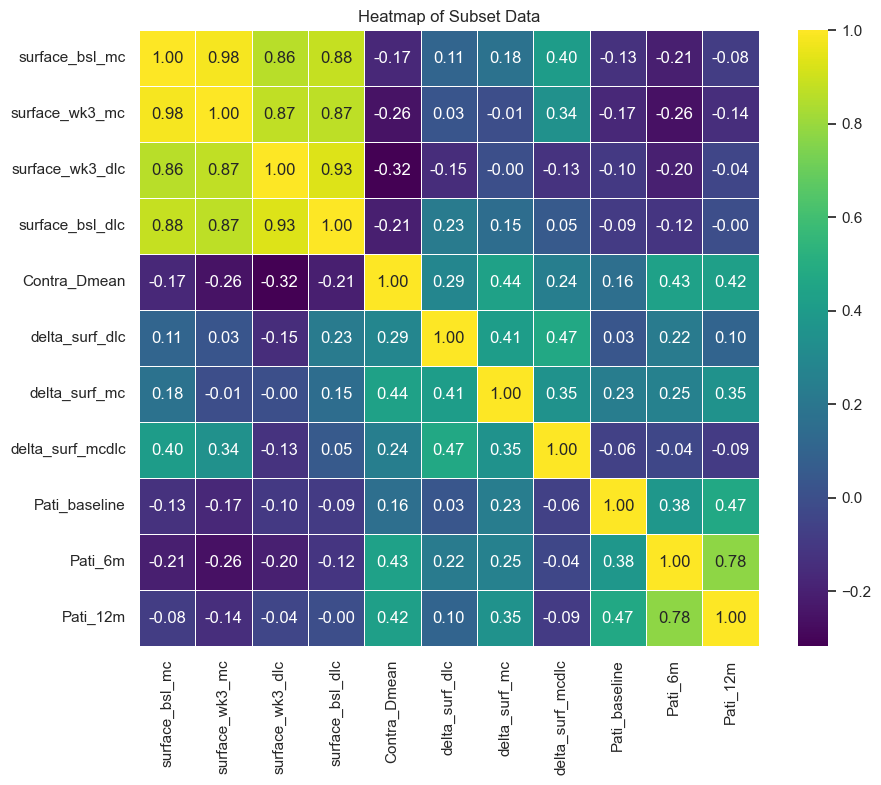

In [35]:
aaa = mc_final_df[['surface_bsl_mc', 'surface_wk3_mc', 'surface_wk3_dlc', 'surface_bsl_dlc', 'Contra_Dmean', 'delta_surf_dlc', 'delta_surf_mc', 'delta_surf_mcdlc','Pati_baseline', 'Pati_6m', 'Pati_12m']]
corre = aaa.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corre, cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Heatmap of Subset Data')
plt.show()

In [227]:
# Check the normality
stat, p_value = shapiro(mc_final_df['delta_surf_dlc'])
print(stat, p_value)

stat, p_value = shapiro(mc_final_df['delta_surf_mc'])
print(stat, p_value)

stat, p_value = shapiro(mc_final_df['delta_surf_mcdlc'])
print(stat, p_value)

0.9857267737388611 0.5359579920768738
0.9774010181427002 0.1800527423620224
0.9909854531288147 0.8634040355682373


In [64]:
# Perform Bartlett's test
statistic, p_value = bartlett(mc_final_df['delta_surf_dlc'], mc_final_df['delta_surf_mc'])

# Print the results
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value < 0.05:
    print("The variances are significantly different.")
else:
    print("There is no significant difference in variances.")

Test Statistic: 27.367477726847138
P-value: 1.6823697101380026e-07
The variances are significantly different.


In [72]:
# Perform Bartlett's test
statistic, p_value = bartlett(mc_final_df['delta_surf_mc'], mc_final_df['delta_surf_mcdlc'])

# Print the results
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value < 0.05:
    print("The variances are significantly different.")
else:
    print("There is no significant difference in variances.")

Test Statistic: 68.40524816040067
P-value: 1.3312279932241978e-16
The variances are significantly different.


In [71]:
# Perform Bartlett's test
statistic, p_value = bartlett(mc_final_df['delta_surf_mcdlc'], mc_final_df['delta_surf_dlc'])

# Print the results
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the p-value against a significance level (e.g., 0.05)
if p_value < 0.05:
    print("The variances are significantly different.")
else:
    print("There is no significant difference in variances.")

Test Statistic: 12.002371538314993
P-value: 0.0005313289490853292
The variances are significantly different.


In [68]:
# Perform the independent t-test
t_statistic, p_value = ttest_ind(mc_final_df['delta_surf_mcdlc'], mc_final_df['delta_surf_mc'])

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

t-statistic: 6.377180880631576
p-value: 1.9992056820093755e-09
Reject the null hypothesis: There is a significant difference between the means.


In [69]:
# Perform the independent t-test
t_statistic, p_value = ttest_ind(mc_final_df['delta_surf_dlc'], mc_final_df['delta_surf_mc'])

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

t-statistic: -0.998279510369815
p-value: 0.3197098270505929
Fail to reject the null hypothesis: There is no significant difference between the means.


In [73]:
# Perform the independent t-test
t_statistic, p_value = ttest_ind(mc_final_df['delta_surf_dlc'], mc_final_df['delta_surf_mcdlc'])

# Print the results
print("t-statistic:", t_statistic)
print("p-value:", p_value)

# Determine the significance
alpha = 0.05  # Set your desired significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the means.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the means.")

t-statistic: -6.266171361725904
p-value: 3.5363154257107238e-09
Reject the null hypothesis: There is a significant difference between the means.


In [70]:
# Perform Bartlett's test
statistic, p_value = kruskal(mc_final_df['delta_surf_dlc'], mc_final_df['delta_surf_mc'], mc_final_df['delta_surf_mcdlc'])

print(statistic, p_value)

44.118953096367136 2.6283975968952263e-10


In [65]:
# Perform Bartlett's test
statistic, p_value = kruskal(mc_final_df['delta_surf_mcdlc'], mc_final_df['delta_surf_mc'])

print(statistic, p_value)

33.41952788351614 7.42744296173908e-09
